In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [11]:
!pip install mtcnn

     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     -------- ------------------------------- 10.2/46.2 kB ? eta -:--:--
     --------------------------------- ---- 41.0/46.2 kB 487.6 kB/s eta 0:00:01
     -------------------------------------- 46.2/46.2 kB 571.0 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
    --------------------------------------- 0.0/2.3 MB 660.6 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.3 MB 991.0 kB/s eta 0:00:03
   - -------------------------------------- 0.1/2.3 MB 939.4 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/2.3 MB 950.9 kB/s eta 0:00:03
   --- ------------------------------------ 0.2/2.3 MB 958.4 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/2.3 MB 942.1 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/2.3 MB 983.9 kB/s eta 0:00:03
   ----- ---------------------------------- 0.3/2.3 MB 919.0 kB/s eta 0:00:03
  

In [2]:
!pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 435.7 kB/s eta 0:00:01
   --------- ----------------------------- 71.7/294.9 kB 653.6 kB/s eta 0:00:01
   ------------------------------ --------- 225.3/294.9 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.7 MB/s eta 0:00:00


In [8]:
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [11]:
!pip install torch

In [9]:
!pip install torchvision

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   - -------------------------------------- 0.0/1.2 MB 325.1 kB/s eta 0:00:04
   --- ------------------------------------ 0.1/1.2 MB 751.6 kB/s eta 0:00:02
   --------- ------------------------------ 0.3/1.2 MB 1.7 MB/s eta 0:00:01
   -------------------- ------------------- 0.6/1.2 MB 2.9 MB/s eta 0:00:01
   ------------------------------- -------- 0.9/1.2 MB 3.7 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 4.1 MB/s eta 0:00:00


In [10]:
!pip install torchsummary

In [25]:
!pip install pywin32

In [12]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import models
import imgaug as ia
from imgaug import augmenters as iaa

import warnings
warnings.filterwarnings("ignore")

In [13]:
from win32com.shell import shell, shellcon
import os

desktop_path = shell.SHGetKnownFolderPath(shellcon.FOLDERID_Desktop)
train_dir = os.path.join(desktop_path, "flora")
valid_dir = os.path.join(desktop_path, "valid")
test_dir = os.path.join(desktop_path, "test")
print("Train Directory:",os.listdir(train_dir))
print("Test Directory: ", os.listdir(test_dir))
print("Valid Directory: ", os.listdir(valid_dir))
CLASS_NAMES = os.listdir(train_dir)

Train Directory: ['Aloe', 'Venerina']
Test Directory:  ['testa', 'testv']
Valid Directory:  ['valida', 'validv']


In [29]:
print("Training data 1:",len(os.listdir(train_dir+'/'+'Aloe')))
print("Training data 2:",len(os.listdir(train_dir+'/'+'Venerina')))
print("Testing data 1:",len(os.listdir(test_dir+'/'+'testv')))
print("Testing data 2:",len(os.listdir(test_dir+'/'+'testa')))
print("Validation data 1:",len(os.listdir(valid_dir+'/'+'validv')))
print("Validation data 2:",len(os.listdir(valid_dir+'/'+'valida')))

Training data 1: 1184
Training data 2: 602
Testing data 1: 40
Testing data 2: 40
Validation data 1: 15
Validation data 2: 16


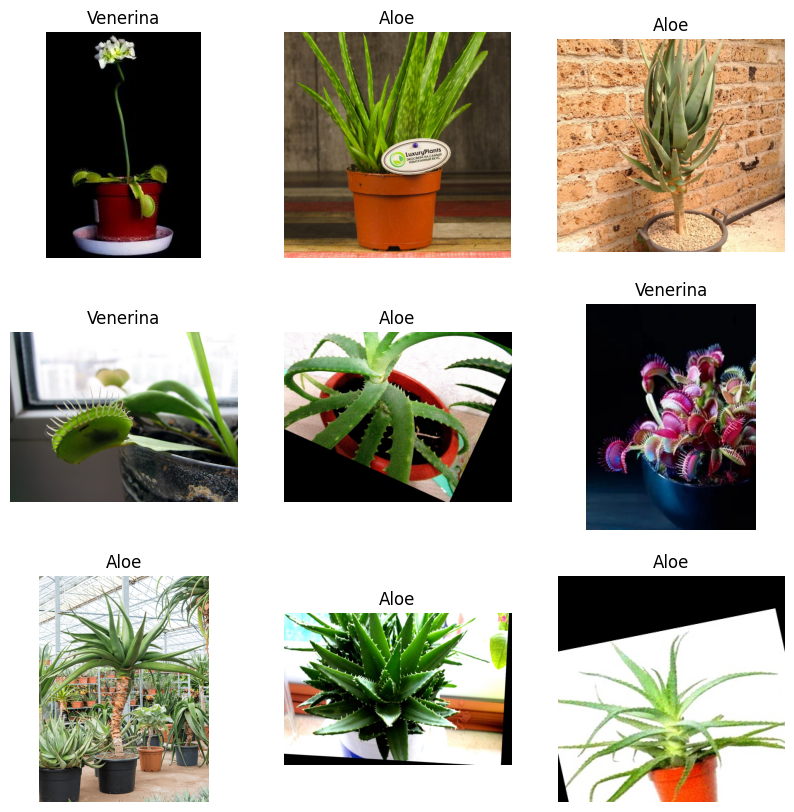

In [15]:
def show_random_images(data_dir, num_images):
    class_names = os.listdir(data_dir)
    num_rows = int(num_images ** 0.5)
    num_cols = int(num_images ** 0.5)
    fig, axarr = plt.subplots(num_rows, num_cols, figsize=(10,10))
    for i in range(num_rows):
        for j in range(num_cols):
            class_num = random.randint(0, len(class_names)-1)
            img_name = random.choice(os.listdir(os.path.join(data_dir, class_names[class_num])))
            img_path = os.path.join(data_dir, class_names[class_num], img_name)
            img = mpimg.imread(img_path)
            axarr[i, j].imshow(img, cmap = 'gray')
            axarr[i, j].set_title(class_names[class_num])
            axarr[i, j].axis('off')
            
    plt.show()

show_random_images(train_dir, 9)

In [16]:
ia.seed(1)

# Example batch of images.
# The array has shape (32, 64, 64, 3) and dtype uint8.

images = np.array(
    [ia.quokka(size=(64, 64)) for _ in range(32)],
    dtype=np.uint8
)

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True) # apply augmenters in random order



In [17]:
foldername_aloe = os.path.join(train_dir,'Aloe')
foldername_venerina = os.path.join(train_dir,'Venerina')
for filename in os.listdir(foldername_aloe):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
    # Загрузка изображения
        image_path = os.path.join(foldername_aloe, filename)
        image = cv2.imread(image_path)
        
        # Применение аугментаций к изображению
        augmented_image = seq(image=image)
        
        # Сохранение аугментированного изображения
        augmented_filename = 'augmented_' + filename
        augmented_image_path = os.path.join(foldername_aloe, augmented_filename)
        cv2.imwrite(augmented_image_path, augmented_image)

for filename in os.listdir(foldername_venerina):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
    # Загрузка изображения
        image_path = os.path.join(foldername_venerina, filename)
        image = cv2.imread(image_path)
        
        # Применение аугментаций к изображению
        augmented_image = seq(image=image)
        
        # Сохранение аугментированного изображения
        augmented_filename = 'augmented_' + filename
        augmented_image_path = os.path.join(foldername_venerina, augmented_filename)
        cv2.imwrite(augmented_image_path, augmented_image)

print("Аугментация завершена.")

Аугментация завершена.


In [18]:
image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        
    ]),
    
    'valid': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

In [19]:
data = {
    'train': datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_dir, transform=image_transforms['valid'])
}

print("Training data: ", len(data['train']))
print("Validation data: ", len(data['valid']))

Training data:  1786
Validation data:  31


In [20]:
BATCH_SIZE = 32
NUM_CLASSES = 2

train_loader = DataLoader(data['train'], batch_size = BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(data['valid'], batch_size = BATCH_SIZE, shuffle=True)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
model = models.resnet50(pretrained = True).to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [23]:
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(64, NUM_CLASSES)
)


model = model.to(device)

In [24]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

In [25]:
num_epochs = 20
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = 0
    valid_loss = 0

    # Training loop
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
    
        # Validation loop
    model.eval()
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        valid_loss += loss.item() * images.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)
    
    # Print training and validation loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

Epoch [1/20], Train Loss: 0.0091, Valid Loss: 0.6886
Epoch [2/20], Train Loss: 0.0099, Valid Loss: 0.6935
Epoch [3/20], Train Loss: 0.0082, Valid Loss: 0.6787
Epoch [4/20], Train Loss: 0.0077, Valid Loss: 0.6422
Epoch [5/20], Train Loss: 0.0080, Valid Loss: 0.5815
Epoch [6/20], Train Loss: 0.0074, Valid Loss: 0.4841
Epoch [7/20], Train Loss: 0.0043, Valid Loss: 0.3734
Epoch [8/20], Train Loss: 0.0053, Valid Loss: 0.2554
Epoch [9/20], Train Loss: 0.0035, Valid Loss: 0.1487
Epoch [10/20], Train Loss: 0.0013, Valid Loss: 0.0887
Epoch [11/20], Train Loss: 0.0018, Valid Loss: 0.0694
Epoch [12/20], Train Loss: 0.0019, Valid Loss: 0.0393
Epoch [13/20], Train Loss: 0.0018, Valid Loss: 0.0307
Epoch [14/20], Train Loss: 0.0010, Valid Loss: 0.0372
Epoch [15/20], Train Loss: 0.0010, Valid Loss: 0.0295
Epoch [16/20], Train Loss: 0.0011, Valid Loss: 0.0146
Epoch [17/20], Train Loss: 0.0008, Valid Loss: 0.0249
Epoch [18/20], Train Loss: 0.0005, Valid Loss: 0.0257
Epoch [19/20], Train Loss: 0.0011, Va

In [30]:
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 98.75 %


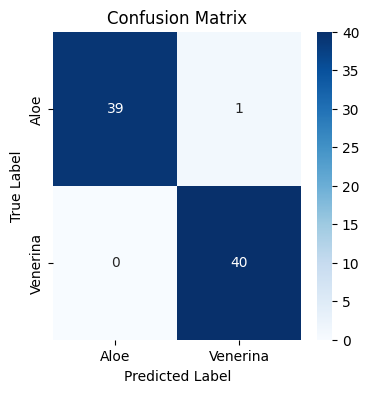

              precision    recall  f1-score   support

        Aloe       1.00      0.97      0.99        40
    Venerina       0.98      1.00      0.99        40

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [31]:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))